In [1]:
import pandas as pd
import numpy as np
import os 
import glob, os
from scipy import stats
from geopy.distance import great_circle
from geopy.distance import geodesic
import geopandas
import contextily as ctx
import matplotlib.pyplot as plt
%matplotlib inline 

# Create JANUARY - MAY 2019,2020 CitiBike Data Frame

In [2]:

#Get 2019,2020 citibike into dataframes, loop through folder, and put data frames in a list 

df_bike_list_2020=[]
for filename in glob.iglob('data/citibike/2020/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2020.append(pd.read_csv(filename))
        
        
df_bike_list_2019=[]
for filename in glob.iglob('data/citibike/2019/**.csv', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_bike_list_2019.append(pd.read_csv(filename))
        


In [3]:
#create 2019,2020 citibike by concating list of dfs
bike_2020_df = pd.concat(df_bike_list_2020)
bike_2019_df = pd.concat(df_bike_list_2019)

In [4]:
#2020 citibike

print(bike_2020_df.shape)
bike_2020_df.head()

(101046, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,226,2020-01-01 00:04:50.1920,2020-01-01 00:08:37.0370,3186,Grove St PATH,40.719586,-74.043117,3211,Newark Ave,40.721525,-74.046305,29444,Subscriber,1984,2
1,377,2020-01-01 00:16:01.6700,2020-01-01 00:22:19.0800,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,-74.050389,26305,Subscriber,1989,2
2,288,2020-01-01 00:17:33.8770,2020-01-01 00:22:22.4420,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,-74.050389,29268,Customer,1989,1
3,435,2020-01-01 00:32:05.9020,2020-01-01 00:39:21.0660,3195,Sip Ave,40.730897,-74.063913,3280,Astor Place,40.719282,-74.071262,29278,Customer,1969,0
4,231,2020-01-01 00:46:19.6780,2020-01-01 00:50:11.3440,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,40.714584,-74.042817,29276,Subscriber,1983,2


In [5]:
#2019 citibike
print(bike_2019_df.shape)
bike_2019_df.head()


(131038, 15)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,201,2019-01-01 03:09:09.7110,2019-01-01 03:12:30.8790,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,29612,Subscriber,1993,1
1,505,2019-01-01 05:18:00.1060,2019-01-01 05:26:25.9050,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,-74.035483,29213,Subscriber,1972,2
2,756,2019-01-01 10:36:33.3400,2019-01-01 10:49:10.2600,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,-74.055701,26164,Subscriber,1985,1
3,1575,2019-01-01 12:43:38.6430,2019-01-01 13:09:54.5280,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,-74.035483,29672,Customer,1969,0
4,1566,2019-01-01 12:43:39.6010,2019-01-01 13:09:46.5100,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,-74.035483,29522,Customer,1969,0


In [6]:
#Add Hyphens to bike df column names
bike_2019_df.columns= pd.Series(bike_2019_df.columns).str.replace(" ","_")
bike_2020_df.columns = pd.Series(bike_2020_df.columns).str.replace(" ","_")

In [7]:
#create time columns for bike 
bike_2019_df["DATE_TIME"] = pd.to_datetime(bike_2019_df["starttime"])
bike_2020_df["DATE_TIME"] =  pd.to_datetime(bike_2020_df["starttime"])

#2020 year, month,days

bike_2020_df["YEAR"] =  bike_2020_df["DATE_TIME"].dt.year
bike_2020_df["MONTH"] =  bike_2020_df["DATE_TIME"].dt.month
bike_2020_df["DAY"] =  bike_2020_df["DATE_TIME"].dt.day

#2019 year, month,days
bike_2019_df["YEAR"] =  bike_2019_df["DATE_TIME"].dt.year
bike_2019_df["MONTH"] =  bike_2019_df["DATE_TIME"].dt.month
bike_2019_df["DAY"] =  bike_2019_df["DATE_TIME"].dt.day


# Get MTA Station Coordinates

In [8]:
# Get the unique list of Stations 

station_info_df = pd.read_csv("data/stations.txt")
station_info_df_small = station_info_df[['Stop Name','GTFS Latitude','GTFS Longitude']]
station_info_df_small = station_info_df_small.drop_duplicates(subset="Stop Name")
station_info_df

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,517,517,S15,SIR,Staten Island,Prince's Bay,SI,SIR,Open Cut,40.525507,-74.200064,St George,Tottenville
492,518,518,S14,SIR,Staten Island,Pleasant Plains,SI,SIR,Embankment,40.522410,-74.217847,St George,Tottenville
493,519,519,S13,SIR,Staten Island,Richmond Valley,SI,SIR,Open Cut,40.519631,-74.229141,St George,Tottenville
494,522,522,S09,SIR,Staten Island,Tottenville,SI,SIR,At Grade,40.512764,-74.251961,St George,NaN


In [9]:
station_info_df.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan


In [10]:
station_info_df[station_info_df["Stop Name"]=='WTC Cortlandt']

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
328,328,328,138,IRT,Broadway - 7Av,WTC Cortlandt,M,1,Subway,40.711835,-74.012188,Uptown & The Bronx,Downtown


In [11]:

print(f'{station_info_df_small.shape} Shape of Station info data frame')
station_info_df_small.head()

(377, 3) Shape of Station info data frame


,Stop Name,GTFS Latitude,GTFS Longitude
0,Astoria - Ditmars Blvd,40.775036,-73.912034
1,Astoria Blvd,40.770258,-73.917843
2,30 Av,40.766779,-73.921479
3,Broadway,40.761820,-73.925508
4,36 Av,40.756804,-73.929575


In [12]:
#create dictionary of stations and their latitudes and longitude


station_info_dict={d['Stop Name']: (d['GTFS Latitude'],d['GTFS Longitude']) for d in station_info_df_small.to_dict(orient='records')}

#Look in the dictionary
print(f'Some Keys of this dictionary {list(station_info_dict.keys())[:5]}\n')

print(f'Some Values of this dictionary {list(station_info_dict.values())[:5]}')




Some Keys of this dictionary ['Astoria - Ditmars Blvd', 'Astoria Blvd', '30 Av', 'Broadway', '36 Av']

Some Values of this dictionary [(40.775036, -73.91203399999999), (40.770258, -73.917843), (40.766779, -73.921479), (40.76182, -73.925508), (40.756803999999995, -73.929575)]


In [13]:
station_info_df.head()

,Station ID,Complex ID,GTFS Stop ID,Division,Line,Stop Name,Borough,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label
0,1,1,R01,BMT,Astoria,Astoria - Ditmars Blvd,Q,N W,Elevated,40.775036,-73.912034,NaN,Manhattan
1,2,2,R03,BMT,Astoria,Astoria Blvd,Q,N W,Elevated,40.770258,-73.917843,Ditmars Blvd,Manhattan
2,3,3,R04,BMT,Astoria,30 Av,Q,N W,Elevated,40.766779,-73.921479,Astoria - Ditmars Blvd,Manhattan
3,4,4,R05,BMT,Astoria,Broadway,Q,N W,Elevated,40.761820,-73.925508,Astoria - Ditmars Blvd,Manhattan
4,5,5,R06,BMT,Astoria,36 Av,Q,N W,Elevated,40.756804,-73.929575,Astoria - Ditmars Blvd,Manhattan


In [14]:
#create function to find_closest mta station
def find_closest_mta_station(latitude,longitude):
    station_distances =  {mta_station:great_circle(station_info_dict[mta_station],(latitude,longitude)).miles for mta_station in station_info_dict} 
    min_station = min(station_distances,key=station_distances.get)
    return min_station
    







In [15]:
#create unique starting and ending bike stations df so we can find the closest MTA stations more quickly

unique_bike_stations_df_2019_start = bike_2019_df.drop_duplicates(subset=["start_station_name"])
unique_bike_stations_df_2019_end = bike_2019_df.drop_duplicates(subset=["end_station_name"])

unique_bike_stations_df_2020_start = bike_2020_df.drop_duplicates(subset=["start_station_name"])
unique_bike_stations_df_2020_end = bike_2020_df.drop_duplicates(subset=["end_station_name"])


unique_bike_stations_df_2019_start = unique_bike_stations_df_2019_start[['start_station_name','start_station_latitude','start_station_longitude']]
unique_bike_stations_df_2019_end = unique_bike_stations_df_2019_end[['end_station_name','end_station_latitude','end_station_longitude']]

unique_bike_stations_df_2020_start = unique_bike_stations_df_2020_start[['start_station_name','start_station_latitude','start_station_longitude']]
unique_bike_stations_df_2020_end = unique_bike_stations_df_2020_end[['end_station_name','end_station_latitude','end_station_longitude']]

In [16]:
#unique bike stations in one df 
unique_bike_stations_start = pd.concat([unique_bike_stations_df_2019_start,unique_bike_stations_df_2020_start]).drop_duplicates(subset="start_station_name")

unique_bike_stations_end = pd.concat([unique_bike_stations_df_2019_end,unique_bike_stations_df_2020_end]).drop_duplicates(subset="end_station_name")

unique_bike_stations_start.head()
unique_bike_stations_end.head()

,end_station_name,end_station_latitude,end_station_longitude
0,Essex Light Rail,40.712774,-74.036486
1,Washington St,40.724294,-74.035483
2,Liberty Light Rail,40.711242,-74.055701
5,JC Medical Center,40.716540,-74.049638
6,Communipaw & Berry Lane,40.714358,-74.066611


# Determine Bike Stations closest to MTA Stations

In [17]:
unique_bike_stations_start['closest_mta_start']=unique_bike_stations_start.apply(lambda x:find_closest_mta_station(x['start_station_latitude'],x['start_station_longitude']),axis=1)
unique_bike_stations_end['closest_mta_end']=unique_bike_stations_end.apply(lambda x:find_closest_mta_station(x['end_station_latitude'],x['end_station_longitude']),axis=1)



In [18]:
#We now have the end stations name with the closest mta station

print(unique_bike_stations_end.shape)
print(unique_bike_stations_end.closest_mta_end.nunique())
unique_bike_stations_end.head(25)


(87, 4)
26


,end_station_name,end_station_latitude,end_station_longitude,closest_mta_end
0,Essex Light Rail,40.712774,-74.036486,Rector St
1,Washington St,40.724294,-74.035483,WTC Cortlandt
2,Liberty Light Rail,40.711242,-74.055701,Bowling Green
5,JC Medical Center,40.716540,-74.049638,WTC Cortlandt
6,Communipaw & Berry Lane,40.714358,-74.066611,Bowling Green
7,Riverview Park,40.744319,-74.043991,14 St
9,Newport PATH,40.727224,-74.033759,Houston St
11,Morris Canal,40.712419,-74.038526,Rector St
14,Exchange Place,40.716247,-74.033459,WTC Cortlandt
16,Grand St,40.715178,-74.037683,WTC Cortlandt


In [19]:
print(unique_bike_stations_start.shape)
print(unique_bike_stations_start.closest_mta_start.nunique())

unique_bike_stations_start.head()

(53, 4)
6


,start_station_name,start_station_latitude,start_station_longitude,closest_mta_start
0,Exchange Place,40.716247,-74.033459,WTC Cortlandt
817,Paulus Hook,40.714145,-74.033552,WTC Cortlandt
1184,City Hall,40.717733,-74.043845,WTC Cortlandt
1687,Grove St PATH,40.719586,-74.043117,WTC Cortlandt
4348,Warren St,40.721124,-74.038051,WTC Cortlandt


In [20]:
#Add closested mta_station to bike df


In [21]:
bike_2019_df_mta = bike_2019_df.merge(unique_bike_stations_start,on=["start_station_name","start_station_latitude",'start_station_longitude'],how="left")
bike_2019_df_mta = bike_2019_df_mta.merge(unique_bike_stations_end,on=["end_station_name","end_station_latitude",'end_station_longitude'],how="left")
print(bike_2019_df_mta.shape)
bike_2019_df_mta.head()

(131038, 21)


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bikeid,usertype,birth_year,gender,DATE_TIME,YEAR,MONTH,DAY,closest_mta_start,closest_mta_end
0,201,2019-01-01 03:09:09.7110,2019-01-01 03:12:30.8790,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,29612,Subscriber,1993,1,2019-01-01 03:09:09.711,2019,1,1,WTC Cortlandt,Rector St
1,505,2019-01-01 05:18:00.1060,2019-01-01 05:26:25.9050,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,29213,Subscriber,1972,2,2019-01-01 05:18:00.106,2019,1,1,WTC Cortlandt,WTC Cortlandt
2,756,2019-01-01 10:36:33.3400,2019-01-01 10:49:10.2600,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,26164,Subscriber,1985,1,2019-01-01 10:36:33.340,2019,1,1,WTC Cortlandt,Bowling Green
3,1575,2019-01-01 12:43:38.6430,2019-01-01 13:09:54.5280,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,29672,Customer,1969,0,2019-01-01 12:43:38.643,2019,1,1,WTC Cortlandt,WTC Cortlandt
4,1566,2019-01-01 12:43:39.6010,2019-01-01 13:09:46.5100,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,29522,Customer,1969,0,2019-01-01 12:43:39.601,2019,1,1,WTC Cortlandt,WTC Cortlandt


In [22]:
bike_2020_df_mta = bike_2020_df.merge(unique_bike_stations_start,on=["start_station_name","start_station_latitude",'start_station_longitude'],how="left")
bike_2020_df_mta = bike_2020_df_mta.merge(unique_bike_stations_end,on=["end_station_name","end_station_latitude",'end_station_longitude'],how="left")
print(bike_2020_df_mta.shape)
bike_2020_df_mta.head()

(101046, 21)


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,bikeid,usertype,birth_year,gender,DATE_TIME,YEAR,MONTH,DAY,closest_mta_start,closest_mta_end
0,226,2020-01-01 00:04:50.1920,2020-01-01 00:08:37.0370,3186,Grove St PATH,40.719586,-74.043117,3211,Newark Ave,40.721525,...,29444,Subscriber,1984,2,2020-01-01 00:04:50.192,2020,1,1,WTC Cortlandt,WTC Cortlandt
1,377,2020-01-01 00:16:01.6700,2020-01-01 00:22:19.0800,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,...,26305,Subscriber,1989,2,2020-01-01 00:16:01.670,2020,1,1,WTC Cortlandt,WTC Cortlandt
2,288,2020-01-01 00:17:33.8770,2020-01-01 00:22:22.4420,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,...,29268,Customer,1989,1,2020-01-01 00:17:33.877,2020,1,1,WTC Cortlandt,WTC Cortlandt
3,435,2020-01-01 00:32:05.9020,2020-01-01 00:39:21.0660,3195,Sip Ave,40.730897,-74.063913,3280,Astor Place,40.719282,...,29278,Customer,1969,0,2020-01-01 00:32:05.902,2020,1,1,NaN,WTC Cortlandt
4,231,2020-01-01 00:46:19.6780,2020-01-01 00:50:11.3440,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,40.714584,...,29276,Subscriber,1983,2,2020-01-01 00:46:19.678,2020,1,1,WTC Cortlandt,WTC Cortlandt


# Create JANUARY - MAY 2019,2020 MTA Data Frame

In [23]:


#Get 2019,2020 MTA into dataframes

df_list_2020=[]
for filename in glob.iglob('data/turnstile_mta/2020/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2020.append(pd.read_csv(filename))
        
        
df_list_2019=[]
for filename in glob.iglob('data/turnstile_mta/2019/**.txt', recursive=True):
    if os.path.isfile(filename): # filter dirs
        df_list_2019.append(pd.read_csv(filename))
        




In [24]:
# Create 2019,2020 dataframes
mta_2020_df = pd.concat(df_list_2020)
mta_2019_df = pd.concat(df_list_2019)



In [25]:
print(mta_2020_df.shape)
mta_2020_df.head()


(4538810, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,03:00:00,REGULAR,7324295,2482512
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,07:00:00,REGULAR,7324305,2482523
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,11:00:00,REGULAR,7324371,2482594
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,15:00:00,REGULAR,7324587,2482647
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/28/2019,19:00:00,REGULAR,7324963,2482713


In [26]:
print(mta_2019_df.shape)
mta_2019_df.head()


(4276811, 11)


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173


In [27]:
#get rid of entries that are zero
mta_2019_df = mta_2019_df[mta_2019_df.ENTRIES > 0]
mta_2020_df = mta_2020_df[mta_2020_df.ENTRIES > 0]

print(f'{mta_2019_df.shape} MTA_2019 Shape')
print(f'{mta_2020_df.shape} MTA 2020 Shape')

(4206499, 11) MTA_2019 Shape
(4470618, 11) MTA 2020 Shape


In [28]:
#create time columns for mta
mta_2019_df["DATE"] = pd.to_datetime(mta_2019_df["DATE"])
mta_2019_df["HOUR"] = pd.to_datetime(mta_2019_df["TIME"],format="%H:%M:%S").dt.hour
mta_2019_df["WEEK"] = mta_2019_df["DATE"].dt.week
mta_2019_df["MONTH"] = mta_2019_df["DATE"].dt.month

mta_2020_df["DATE"] = pd.to_datetime(mta_2020_df["DATE"])
mta_2020_df["HOUR"] = pd.to_datetime(mta_2020_df["TIME"],format="%H:%M:%S").dt.hour
mta_2020_df["WEEK"] = mta_2020_df["DATE"].dt.week
mta_2020_df["MONTH"] = mta_2020_df["DATE"].dt.month


In [29]:
#exits columns title has many spaces after, make new column with correct name
mta_2019_df['EXITS']=mta_2019_df.iloc[:,10]
mta_2020_df['EXITS']=mta_2020_df.iloc[:,10]

mta_2019_df = mta_2019_df.drop(columns=mta_2019_df.columns.to_list()[10])
mta_2020_df = mta_2020_df.drop(columns=mta_2020_df.columns.to_list()[10])

# CitiBike / MTA map

In [30]:
bike_2019_df_mta[['start_station_latitude','start_station_longitude','end_station_latitude','end_station_longitude']]

,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,40.716247,-74.033459,40.712774,-74.036486
1,40.716247,-74.033459,40.724294,-74.035483
2,40.716247,-74.033459,40.711242,-74.055701
3,40.716247,-74.033459,40.724294,-74.035483
4,40.716247,-74.033459,40.724294,-74.035483
...,...,...,...,...
131033,40.719586,-74.043117,40.712774,-74.036486
131034,40.719586,-74.043117,40.712774,-74.036486
131035,40.719586,-74.043117,40.726012,-74.050389
131036,40.711242,-74.055701,40.714358,-74.066611


In [32]:
#geo data frame with coordinates

gdf = geopandas.GeoDataFrame.from_file("data/shapefile/")
bike_2019_geo_df_mta_start = geopandas.GeoDataFrame(
bike_2019_df_mta, geometry=geopandas.points_from_xy(bike_2019_df_mta.start_station_longitude, bike_2019_df_mta.start_station_latitude))



In [33]:
bike_2019_geo_df_mta_start.iloc[:,-1]


0         POINT (-74.03346 40.71625)
1         POINT (-74.03346 40.71625)
2         POINT (-74.03346 40.71625)
3         POINT (-74.03346 40.71625)
4         POINT (-74.03346 40.71625)
                     ...            
131033    POINT (-74.04312 40.71959)
131034    POINT (-74.04312 40.71959)
131035    POINT (-74.04312 40.71959)
131036    POINT (-74.05570 40.71124)
131037    POINT (-74.05570 40.71124)
Name: geometry, Length: 131038, dtype: geometry

In [34]:
test = geopandas.GeoSeries(bike_2019_geo_df_mta_start.iloc[:,-1])
test

0         POINT (-74.03346 40.71625)
1         POINT (-74.03346 40.71625)
2         POINT (-74.03346 40.71625)
3         POINT (-74.03346 40.71625)
4         POINT (-74.03346 40.71625)
                     ...            
131033    POINT (-74.04312 40.71959)
131034    POINT (-74.04312 40.71959)
131035    POINT (-74.04312 40.71959)
131036    POINT (-74.05570 40.71124)
131037    POINT (-74.05570 40.71124)
Name: geometry, Length: 131038, dtype: geometry

In [35]:
bike_2019_geo_df_mta_end = geopandas.GeoDataFrame(
bike_2019_df_mta, geometry=geopandas.points_from_xy(bike_2019_df_mta.end_station_longitude, bike_2019_df_mta.end_station_latitude))

In [36]:
derrr

0         POINT (-74.03346 40.71625)
1         POINT (-74.03346 40.71625)
2         POINT (-74.03346 40.71625)
3         POINT (-74.03346 40.71625)
4         POINT (-74.03346 40.71625)
                     ...            
131033    POINT (-74.04312 40.71959)
131034    POINT (-74.04312 40.71959)
131035    POINT (-74.04312 40.71959)
131036    POINT (-74.05570 40.71124)
131037    POINT (-74.05570 40.71124)
Name: geometry, Length: 131038, dtype: geometry

In [37]:
bike_2019_geo_df_mta_start.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,usertype,birth_year,gender,DATE_TIME,YEAR,MONTH,DAY,closest_mta_start,closest_mta_end,geometry
0,201,2019-01-01 03:09:09.7110,2019-01-01 03:12:30.8790,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,Subscriber,1993,1,2019-01-01 03:09:09.711,2019,1,1,WTC Cortlandt,Rector St,POINT (-74.03649 40.71277)
1,505,2019-01-01 05:18:00.1060,2019-01-01 05:26:25.9050,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,Subscriber,1972,2,2019-01-01 05:18:00.106,2019,1,1,WTC Cortlandt,WTC Cortlandt,POINT (-74.03548 40.72429)
2,756,2019-01-01 10:36:33.3400,2019-01-01 10:49:10.2600,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,Subscriber,1985,1,2019-01-01 10:36:33.340,2019,1,1,WTC Cortlandt,Bowling Green,POINT (-74.05570 40.71124)
3,1575,2019-01-01 12:43:38.6430,2019-01-01 13:09:54.5280,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,Customer,1969,0,2019-01-01 12:43:38.643,2019,1,1,WTC Cortlandt,WTC Cortlandt,POINT (-74.03548 40.72429)
4,1566,2019-01-01 12:43:39.6010,2019-01-01 13:09:46.5100,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,Customer,1969,0,2019-01-01 12:43:39.601,2019,1,1,WTC Cortlandt,WTC Cortlandt,POINT (-74.03548 40.72429)


In [38]:
bike_2019_geo_df_mta_end.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,usertype,birth_year,gender,DATE_TIME,YEAR,MONTH,DAY,closest_mta_start,closest_mta_end,geometry
0,201,2019-01-01 03:09:09.7110,2019-01-01 03:12:30.8790,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,...,Subscriber,1993,1,2019-01-01 03:09:09.711,2019,1,1,WTC Cortlandt,Rector St,POINT (-74.03649 40.71277)
1,505,2019-01-01 05:18:00.1060,2019-01-01 05:26:25.9050,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,Subscriber,1972,2,2019-01-01 05:18:00.106,2019,1,1,WTC Cortlandt,WTC Cortlandt,POINT (-74.03548 40.72429)
2,756,2019-01-01 10:36:33.3400,2019-01-01 10:49:10.2600,3183,Exchange Place,40.716247,-74.033459,3192,Liberty Light Rail,40.711242,...,Subscriber,1985,1,2019-01-01 10:36:33.340,2019,1,1,WTC Cortlandt,Bowling Green,POINT (-74.05570 40.71124)
3,1575,2019-01-01 12:43:38.6430,2019-01-01 13:09:54.5280,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,Customer,1969,0,2019-01-01 12:43:38.643,2019,1,1,WTC Cortlandt,WTC Cortlandt,POINT (-74.03548 40.72429)
4,1566,2019-01-01 12:43:39.6010,2019-01-01 13:09:46.5100,3183,Exchange Place,40.716247,-74.033459,3638,Washington St,40.724294,...,Customer,1969,0,2019-01-01 12:43:39.601,2019,1,1,WTC Cortlandt,WTC Cortlandt,POINT (-74.03548 40.72429)


In [39]:
#reproject  
bike_2019_geo_df_mta_start.crs = {'init' :'epsg:4326'}  
bike_2019_geo_df_mta_start = bike_2019_geo_df_mta_start.to_crs(epsg=3857)

bike_2019_geo_df_mta_end.crs = {'init' :'epsg:4326'}  
bike_2019_geo_df_mta_end = bike_2019_geo_df_mta_end.to_crs(epsg=3857)

In [40]:

gdf = gdf.to_crs({'init' :'epsg:4326'}) 



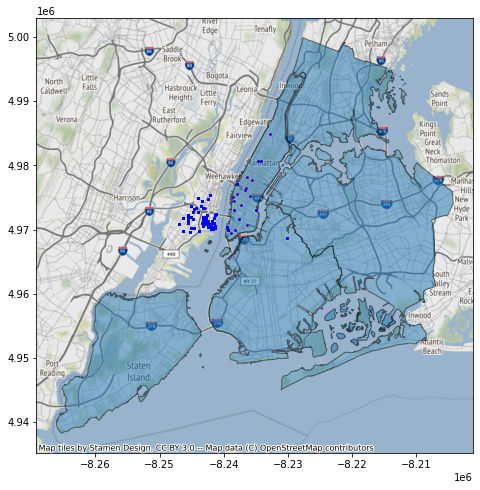

In [42]:
df = geopandas.read_file(geopandas.datasets.get_path('nybb'))

df = df.to_crs(epsg=3857)

ax = df.plot(figsize=(8, 8), alpha=0.5, edgecolor='k')
bike_2019_geo_df_mta_start.plot(ax=ax,color="red",markersize=2.0)
bike_2019_geo_df_mta_end.plot(ax=ax,color="blue",markersize=2.0)

ctx.add_basemap(ax)

plt.show()


In [ ]:
bike_2019_geo_df_mta_start.tail()

In [ ]:
bike_2019_geo_df_mta_end.tail()

In [ ]:
bike_2019_geo_df_mta.crs = {'init' :'epsg:4326'}  




In [ ]:
bike_2019_geo_df_mta = bike_2019_geo_df_mta.to_crs(epsg=3857)

In [ ]:
bike_2019_geo_df_mta

In [ ]:
df['ENTRIES_DIFF']=( df.groupby(['STATION_ID','UNIT','SCP'],as_index=False)['ENTRIES']
                           .transform(pd.Series.diff)['ENTRIES']
                       )
